# Data Cleaning and Reformatting Variables (Python Version) Case Study
#### MSDS 7333 - Quantifying the World - 04/28/17
#### Author: James Tsai, Wid Sogata     
===========================================================================================
### Abstract
Data munging or data wrangling is a process of manually cleaning and converting or mapping data from raw form into a certain format that allows for more convenient consumption of the data with the help of semi-automated tools. In this case study, we intend to demonstrate one of the approaches on how to conduct this essential data preparation steps before conducting analysis.

Keywords:
Data Cleaning, Data Munging, Formatting, Converting, NULL Values. 

### Introduction
Our goal in this case study is to transform the raw text tables of race results from yearly Cherry Blossom Ten Miles Run in D.C. into data that can be analyzed in R. These tables are downloaded from the Web and stored in files, named 1999.txt, 2000.txt, ..., 2012.txt in a directory called WomenTxt for women.  By inspection, we see that a call to read.table() will not properly read the text into a data frame because the information, e.g., place and division, are separated by blanks but blanks also appear in the data values, i.e., blanks also occur where they are not being used as variable separators. For example, for the runner’s hometown, we see values of Kenya, Tucson AZ, and Blowing Rock NC. The blanks between the different parts of hometown will confuse read.table


### Method

We need a customized approach to read these "tables". From the figures, it appears that the variables are formatted to occupy particular positions in each line of text. That is, the runner’s finishing place occupies the first 5 characters, then comes a blank character, the runner’s place in his or her division appears in the next 11 spaces, and so on. While few of the results line up, we see that the columns are mostly not identical across these tables. Given the changes in formats from year to year, we can extract the values from the tables either by programmatically interpreting the format or by using year-dependent fixed-width formats. We take this approach and figure out which column is which by programmatically inspecting the table header.
<br>
For this analysis, due to different data collected form year to year, we are going to use the following data for the analysis:
* Name (name) - Name of the runner - Characters 
* Hometown (home) - Hometown of the runner - Characters
* Age (ag) - Age of the runner - Numeric 
* Gun Time (gun) - The race time from initial pistol shot, regardless of when the runner actually crosses the starting line - Characters (hh:mm:ss)
* Net Time (net) - The race time counted from when the runner actually crosses the starting line - Characters (hh:mm:ss)
* Time (time) - Another time variable. This variable is used when either gun time or net time is not available - Characters (hh:mm:ss)
<br>

We are using Python version 2.7 running on Jupyter Notebook to perform this analysis.

#### Data Extraction from Web Source
We start the process by extracting the data from websource <i>http://www.cherryblossom.org/<i>

In [1]:
# Import packages needed.
import urllib
import urllib2
import pandas as pd
import numpy as np
import matplotlib as plt

# Set base URL
url = "http://www.cherryblossom.org/"
urls = []

In [2]:
# Get all link path to the race results data from the homepage 
womenURLs = [  "results/2001/oof_f.html",
               "results/2002/ooff.htm", 
               "results/2003/CB03-F.HTM",  
               "results/2004/women.htm", 
               "results/2005/CB05-F.htm",
               "results/2006/women.htm",
               "results/2007/women.htm",
               "results/2008/women.htm", 
               "results/2009/09cucb-F.htm",
               "results/2010/2010cucb10m-f.htm",
               "results/2011/2011cucb10m-f.htm",
               "results/2012/2012cucb10m-f.htm" ]

In [3]:
# Paste the homepage URL to each of the link path of results pages to create complete URLs.
for link in womenURLs:
    urls.append(url + link)

In [4]:
urls

['http://www.cherryblossom.org/results/2001/oof_f.html',
 'http://www.cherryblossom.org/results/2002/ooff.htm',
 'http://www.cherryblossom.org/results/2003/CB03-F.HTM',
 'http://www.cherryblossom.org/results/2004/women.htm',
 'http://www.cherryblossom.org/results/2005/CB05-F.htm',
 'http://www.cherryblossom.org/results/2006/women.htm',
 'http://www.cherryblossom.org/results/2007/women.htm',
 'http://www.cherryblossom.org/results/2008/women.htm',
 'http://www.cherryblossom.org/results/2009/09cucb-F.htm',
 'http://www.cherryblossom.org/results/2010/2010cucb10m-f.htm',
 'http://www.cherryblossom.org/results/2011/2011cucb10m-f.htm',
 'http://www.cherryblossom.org/results/2012/2012cucb10m-f.htm']

We are now ready to donwload the data.

In [5]:
# Retrieve data from web site in html format.
start_year = 2001
for url in urls: 
    file_name = str(start_year) + ".htm"
    start_year += 1
    u = urllib2.urlopen(url)
    f = open(file_name, 'wb')
    meta = u.info()
    file_size = int(meta.getheaders("Content-Length")[0])
    print "Downloading: %s Bytes: %s" % (file_name, file_size)

    file_size_dl = 0
    block_sz = 8192
    while True:
        buffer = u.read(block_sz)
        if not buffer:
            break

        file_size_dl += len(buffer)
        f.write(buffer)
        status = r"%10d  [%3.2f%%]" % (file_size_dl, file_size_dl * 100. / file_size)
        status = status + chr(8)*(len(status)+1)
        print status,

    f.close()

Downloading: 2001.htm Bytes: 217909
      8192  [3.76%]      16384  [7.52%]      24576  [11.28%]      32768  [15.04%]      40960  [18.80%]      49152  [22.56%]      57344  [26.32%]      65536  [30.07%]      73728  [33.83%]      81920  [37.59%]      90112  [41.35%]      98304  [45.11%]     106496  [48.87%]     114688  [52.63%]     122880  [56.39%]     131072  [60.15%]     139264  [63.91%]     147456  [67.67%]     155648  [71.43%]     163840  [75.19%]     172032  [78.95%]     180224  [82.71%]     188416  [86.47%]   

In [6]:
! ls *.htm

2001.htm 2003.htm 2005.htm 2007.htm 2009.htm 2011.htm
2002.htm 2004.htm 2006.htm 2008.htm 2010.htm 2012.htm


For the next step, we extract "text" data from each html file. BeautifulSoup is a Python library that can be used for pulling data out of HTML.

In [7]:
from bs4 import BeautifulSoup

# Loop to read each file 
for year in range(2001, 2013):
    htmname = str(year) + ".htm"
    filename = str(year) + ".txt"
    soup = BeautifulSoup(open(htmname))
    
    # Get text from html file
    htm = soup.find('pre').get_text()  
    with open(filename,"w") as out:
        for i in range(0, len(htm)):
            # Write out to .txt file 
            try:
                out.write(htm[i])
            except Exception:
                1+1  

/Users/james/anaconda/envs/gl-env/lib/python2.7/site-packages/bs4/__init__.py:166: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

To get rid of this warning, change this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "lxml")

  markup_type=markup_type))


In [8]:
! ls 20??.txt

2001.txt 2003.txt 2005.txt 2007.txt 2009.txt 2011.txt
2002.txt 2004.txt 2006.txt 2008.txt 2010.txt 2012.txt


We can look at an example of the txt file created and remove htm files. 

In [9]:
!rm *.htm
!head 2002.txt

We also look at the number of rows of each file for verification.

In [10]:
for year in range(2001, 2013):
    num_lines = sum(1 for line in open(str(year)+'.txt'))
    print str(year) + '.txt' +  ' has ' + str(num_lines) + ' lines'

2001.txt has 2976 lines
2002.txt has 3338 lines
2003.txt has 3547 lines
2004.txt has 3907 lines
2005.txt has 4342 lines
2006.txt has 5445 lines
2007.txt has 5699 lines
2008.txt has 6405 lines
2009.txt has 8333 lines
2010.txt has 8863 lines
2011.txt has 9038 lines
2012.txt has 9738 lines


### Closer Look at The Data
Once we have all the data files available, we then need to take a closer look to each file to ensure they have the same format before we can continue with extracting the values from each variables for analysis.
We need a customized approach to reach this "table". From the look of each files, it appears that the variables are formatted to occupy particular positions in each line of text similar to tables. For examples, the runner’s finishing place occupies the first 5 characters, then comes a blank character, the runner’s place in his or her division appears in the next 11 spaces, and so on. While some of the columns of in some of the years are identically lined up, we see that on certain years, the columns are not identical across these tables. Given the changes in formats from year to year, we can extract the values from the tables either by programmatically interpreting the format or by using year-dependent fixed-width formats. We take this approach and figure out which column is which by programmatically inspecting the table header, especially using the separator row similar to "===" as our guidance on where the separations for each variables are. Figure 1 show an example of formatting that we intend to follow accross the data.
<br>
Additionally, we decided we are only interested in the variables "Name", "Hometown", "Ag", "Gun", "Net", and "Time".

![image](fig_1.png)
<br>
<center> Figure 1. Screen Shot of the 1999 Female Race Results.  </center>


For the sake of brevity, we are going to skip the files that are in general formatted according to format we wanted. From our inspection, we found there are 3 files (2001, 2003 and 2006) that need to be added/reformatted to conform our format requirements.

#### Year 2001

On Year 2001, we notice that the table data is missing the variables header and also the separator row as shown in Figure 2. 

![image](fig_2.png)
<br>
<center> Figure 2. Screen Shot of the 2001 Female Race Results. </center> 

We notice there are blank lines at the beginning of the file, so we remove those first. We use regular expression at OS level to locate these lines and remove them.

In [11]:
!head 2001.txt

In [12]:
# Remove blank lines at the top of the files.
!cp 2001.txt 2001_tmp.txt
!grep -v -e '^[[:space:]]*$' 2001_tmp.txt > 2001.txt ; rm 2001_tmp.txt
!head 2001.txt

We recreate the header and separator row on the following steps. First, we get the row number of the first records and the entire row.

In [13]:
import re
import sys
with open('2001.txt', 'r') as f:
    for line in f:
        m = re.search("^    1", line)
        line = line.lower()
        if m:
            break  

Next, we get the location of the first character of each column where we can use them to separate the variables. 

In [14]:
# Get the location of first character from each variable.
placeStart = 1
divStart = line.index('6002') 
nameStart = line.index('elana') + 1
ageStart = line.index('34') + 1
homeStart = line.index('rep') + 1
gunStart = line.index('52:15') - 1 
netStart = line.index('52:16#') - 1

# Add the last variable "time"
timeStart = netStart + 9

# Put the locations in a list headerLoc.
headerLoc = [placeStart, divStart, nameStart, ageStart, homeStart,  gunStart, netStart, timeStart]
headerLoc

[1, 7, 13, 35, 38, 57, 65, 74]

We can find the spacing/width of each variables by deducting the next variable with the previous minus 1 to account for the empty space (" ") as the separator.

In [15]:
spacerRowL = np.diff(headerLoc)
spacerRowL = np.append(spacerRowL, 8)
spacerRowL

array([ 6,  6, 22,  3, 19,  8,  9,  8])

The difference in the headerLoc elements can be used to create spacing for the header and separator row.

In [16]:
# Set header variables
header_tmp = ["Place", "Div", "Name", "Ag", "Home", "GunTime", "NetTime", "Pace"]
header = []
x = 0
for i in spacerRowL:
    header_t = np.core.defchararray.ljust(header_tmp[x], i, fillchar= ' ')
    header = np.append(header, header_t)
    x += 1

# Join the header into single string    
first = "".join(header)

In [17]:
# Create header/separator line
div = []
x = 0
for i in spacerRowL:
    div_t = np.core.defchararray.ljust("", i-1, fillchar= '=')
    div = np.append(div, div_t)
    x += 1
    
#first = "".join(header)
# Join header separator row into single string
second = " ".join(div)

# Print result
print first
print second

Place Div   Name                  Ag Home               GunTime NetTime  Pace    
===== ===== ===================== == ================== ======= ======== =======


Then we write the change back to the file.

In [18]:
with file('2001.txt', 'r') as original: data = original.read()
with file('2001.txt', 'w') as modified: modified.write(first + '\n' + second + '\n' + data)

In [19]:
!head 2001.txt

Place Div   Name                  Ag Home               GunTime NetTime  Pace    
===== ===== ===================== == ================== ======= ======== =======










### Year 2003

On Year 2003, we notice that the separator line is misaligned with the data starting from "Name" variable.
<br>
<br>
![image](fig_3.png)
<br>
<center> Figure 3. Screen Shot of the 2003 Female Race Results.

We can fix this problem by simply shift the header separator by adding space and "=" character at starting of "Name" variable location.  

In [20]:
!cp 2003.txt 2003tmp.txt

f = open('2003tmp.txt')
fout = open('2003.txt', 'w')
flines = f.readlines()

for line in flines:
    # Get header and separator row location.
    m = re.search("Name", line)
    n = re.search("=====", line)
    if m:
        header = line
        nameStart = line.index('Name')
    if n:
        # Split the separator, add spaces and rejoin the separator.
        headerln1 = line[0:nameStart-2]
        headerln2 = line[nameStart:len(line)]
        line = headerln1 + "  =" + headerln2
    fout.write(line)       
fout.close()
f.close()


In [21]:
# Verify that the problem is fixed
!head 2003.txt

#### Year 2006
On year 2006, we notice that there isn't any separation in the separator row between "Hometown" and "Net Time". 
<br>
![image](fig_4.png)
<br>
<center> Figure 4. Screen Shot of the 2001 Female Race Results with the captured error </center>
<BR>
We can fix this problem, first by reading the files and find the location of first character in "Net Time" variable. We can then do similar step to the previous year by simply adding additional space as a separator.

In [22]:
!cp 2006.txt 2006tmp.txt

f = open('2006tmp.txt', 'r')
fout = open('2006.txt', 'w')

flines = f.readlines()

for line in flines:
    # Get header and separator row location.
    m = re.search("Net Tim", line)
    n = re.search("===", line)
    if m:
        header = line
        netStart = line.index('Net Tim')
    if n:
        # Split the separator, add spaces and rejoin the separator.
        headerln1 = line[0:netStart-1]
        headerln2 = line[netStart:len(line)]
        line =  headerln1 + " " + headerln2    
    fout.write(line) 
    
fout.close()
f.close()

In [23]:
!head 2006.txt

### Removing Footnotes
Upon further observation, we also found that most files have footnotes that need to be removed before extracing the data. We  We use regular expression to locate these footnotes and remove them.

<br>
![image](fig_5.png)
<center> Figure 5. Screen Shot of Footnotes in the last Few Rows.

In [24]:
%%bash

for file in $(ls 20??.txt); do
    cp ${file} ${file}.tmp 
    grep -v '^[[:space:]]*# \|^[[:space:]]*\*' ${file}.tmp > ${file}
done
rm *.tmp

### Extracting Values from Variables
Once the files conform with the format that we intended, we can start with the extraction of the data from the text file. We encapsulate the task of finding the starting and ending positions of the columns into a function, which we call locFinder(). In the function, we call 2 other function getHeaderPos() and getHeaderEndPos to get the first position of each variable and the length of those variables. From the postitions provided by return values we can use them to extract data using Pandas fixed width format function.  

In [25]:
# Get the first character position for each variable. Notice that we are only 
# interested in "Name", "Hometown", "Age" and the "Time" ("net" or "time" - in that order)

def getHeaderPos(str):
    str = str.lower()
    nameStart = str.index('name') 
    homeStart = str.index('home') 
    ageStart = str.index('ag')
    if re.search('net', str):
        timeStart = str.index('net')
    if re.search(' time', str):
        timeStart = str.index('time') - 1
    return [nameStart, ageStart, homeStart, timeStart]

In [26]:
# Get the last character position for each variable.
def getHeaderEndPos(hdrstr, hdrlnstr):
    hdrlst = hdrstr.lower().split()
    hdrlnlst = hdrlnstr.split()
    # Remove 'tim' and '/tot' from the header to ensure the number of 
    # header variable is consistent
    while "tim" in [x.lower() for x in hdrlst]: hdrlst.remove("tim")
    while "/tot" in [x.lower() for x in hdrlst]: hdrlst.remove("/tot")  
    timeLen = 7
    for num, name in enumerate(hdrlst):
        if name == "name":
            nameLen = len(hdrlnlst[num])
        if name == "ag":
            ageLen = len(hdrlnlst[num]) + 1
        if name == "home" or name == "hometown":
            homeLen = len(hdrlnlst[num])
    return [nameLen, ageLen, homeLen, timeLen]             

In [27]:
# Combine the fix locations of each variables and also the row location of header separator
def locFinder(filename):
    f = open(filename)     
    for num, line in enumerate(f):
            m = re.search("Place", line)
            n = re.search("===", line)
            if m:
                header = line
                pos = getHeaderPos(line)
            if n:
                headerline = line
                hdrlen = getHeaderEndPos(header, headerline)
                num = num + 1
                break
    endpos = [sum(x) for x in zip(pos, hdrlen)]
    
    return [num, pos, endpos]


Now we can create a single data frame from all the files by using pandas fixed width extractor with the location provided by the previous functions.  We add additional columns year and gender for data frame as well.

In [28]:
# create data frame from all files.

# df container
dfyears = []

# Loop to each files
for file in range(2001, 2013):
    filename = str(file)+".txt"
    
    # Get the location of each variables.
    colLocs = locFinder(filename)
    
    # Extract data from file using fixed width location and insert it into the df container
    dfyear = pd.read_fwf(filename,
                         comment = '# ',
                         names=["Name","Age", "Hometown", "RaceTime"],
                         header=None,
                         skiprows=colLocs[0],
                         colspecs=[(colLocs[1][0],colLocs[2][0]),
                                   (colLocs[1][1],colLocs[2][1]),
                                   (colLocs[1][2],colLocs[2][2]),
                                   (colLocs[1][3],colLocs[2][3])])
    # Add column year and gender into the dataframe
    dfyear['Year'] = file
    dfyear['Sex'] = 'F'
    
    # Append the year data frame to df container.
    dfyears.append(dfyear) 

# Combine all data frames into a single data frame df_all    
df_all = pd.concat(dfyears, ignore_index=False)

# Remove text files since no longer needed
!rm *.txt

Our next step is to remove all "NA" values from the data frame. We print out the summary info after.

In [29]:
df_all.dropna(inplace=True)
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71376 entries, 0 to 9729
Data columns (total 6 columns):
Name        71376 non-null object
Age         71376 non-null object
Hometown    71376 non-null object
RaceTime    71376 non-null object
Year        71376 non-null int64
Sex         71376 non-null object
dtypes: int64(1), object(5)
memory usage: 3.8+ MB


There are 71376 record entries in the data frame with the size of ~3.8MB.

In [30]:
# Print first few lines of data frame.
df_all.head()

Name Age         Hometown RaceTime  Year Sex
0       Elana MEYER  34  Rep Of S.africa    52:16  2001   F
1  Lydia GRIGORIEVA  27           Russia    53:15  2001   F
2   Eyerusalem KUMA  20         Ethiopia    53:19  2001   F
3     Milena GLUSAC  25              Usa    53:34  2001   F
4    Olga KOVPOTINA  31           Russia    54:03  2001   F

<center> Table 1. First Few Rows of Data Frame </center>  

For analysis purpose we need to convert the string format of the race time to numeric. We create the following function convertToMinutes() to do this.

In [31]:
def convertToMinutes(x):
    m = x.split(':')
    if len(m) == 2:
        return float(m[0]) + float(m[1])/60
    if len(m) == 3:
        return float(m[0])*60 + float(m[1]) + float(m[2])/60

In [32]:
df_all['RaceTime'] = df_all['RaceTime'].apply(lambda x: convertToMinutes(x)) 

We can see that "RaceTime" is now in numeric format.

In [33]:
df_all.head()

Name Age         Hometown   RaceTime  Year Sex
0       Elana MEYER  34  Rep Of S.africa  52.266667  2001   F
1  Lydia GRIGORIEVA  27           Russia  53.250000  2001   F
2   Eyerusalem KUMA  20         Ethiopia  53.316667  2001   F
3     Milena GLUSAC  25              Usa  53.566667  2001   F
4    Olga KOVPOTINA  31           Russia  54.050000  2001   F

<center> Table 2. First Few Rows of Data Frame with Time Conversion </center>  
We have completed data cleaning and reformatting at this step. On the next step, we show some examples of data analysis that can be carried out against the data frame. 

### Age Distribution Plot
On the next steps we are going to plot runner's age distribution for each year. Matplotlib is a popular Python package that can be utilized for this task.

In [34]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

df_age_plot = df_all[['Year','Age']]
df_age_plot2 = df_age_plot[df_age_plot['Age']!='XX']

# We need to realign the format of the frame by pivotting the columns to be displayed. 
df_age_plot3 = df_age_plot2.pivot(columns='Year', values='Age')

In [35]:
# Show the DataFrame that has been pivoted 
df_age_plot3.head()

Year 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012
0      34   29   22   24   34   32   24   20   21   23   25   26
1      27   20   30   31   29   30   23   25   21   24   22   29
2      20   35   36   28   29   32   33   34   22   22   30   30
3      25   27   24   20   35   33   24   35   19   23   30   26
4      31   33   32   23   27   30   33   24   36   33   28   29

<center> Table 3. Pivoted Data Frame for Age Data </center> 

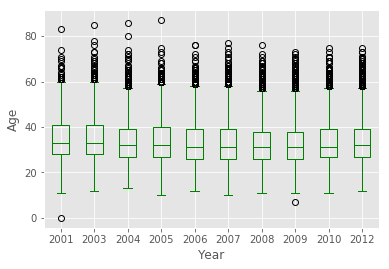

In [36]:
# Boxplot of Age by Year
plt.figure(figsize=(50, 50))
plt.style.use('ggplot')
df_age_plot3.plot(kind='box', color='g')
plt.xlabel('Year')
plt.ylabel('Age')

<center> Figure 5. Boxlot of Runner's Age Distribution per Year. </center>  
Another popular package to plot data is PlotLy. It has a nicer display and more feature in comparison to basic plotting with matplotlib. 

In [37]:
# Boxplot in Plotly for nicer visual
import plotly.plotly as py
import plotly.graph_objs as go
import cufflinks as cf
import pandas as pd
import numpy as np

In [38]:
py.sign_in('jtsai', 'gcvdhnRmGfPFDJcVvJj1')
cf.set_config_file(offline=False, world_readable=True, theme='ggplot')
layout = go.Layout(
    title = "Age Distribution",
    xaxis = dict(
        title = 'Year'),
    yaxis = dict(
       title = "Age"))
df_age_plot3.iplot(kind='box',
                   layout = layout)

<center> Figure 6. Boxlot of Runner's Age Distribution per Year using Plotly\*. </center>  
\*The plot created by Plotly cannot be displayed unless the notebook is re-ran. The following is snapshot image of the same plot.
![image](fig_6.png)

### Race Time plot

Lastly, we are going to plot Race Time to see the distribution of runner's running time from each year. We have to do pivotting on the data similar to the previous plot. 

In [39]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

df_racetime_plot = df_all[['Year','RaceTime']]
df_racetime_plot2 = df_racetime_plot.pivot(columns='Year', values='RaceTime')

In [40]:
# Show the DataFrame that has been pivoted 
df_racetime_plot2.head()

Year       2001       2002       2003       2004       2005       2006  \
0     52.266667  52.833333  53.700000  52.100000  52.016667  52.183333   
1     53.250000  52.883333  53.816667  52.966667  53.283333  52.650000   
2     53.316667  53.233333  53.950000  53.133333  54.266667  55.300000   
3     53.566667  53.600000  54.983333  53.466667  54.950000  55.550000   
4     54.050000  53.616667  55.350000  53.733333  55.283333  55.700000   

Year       2007       2008       2009       2010       2011       2012  
0     51.066667  54.033333  53.533333  51.850000  54.000000  54.000000  
1     52.083333  54.050000  53.916667  52.650000  54.000000  54.033333  
2     53.033333  54.066667  53.966667  53.366667  54.016667  54.050000  
3     53.066667  54.083333  54.433333  54.616667  55.016667  54.050000  
4     53.083333  55.000000  54.450000  54.666667  56.016667  54.050000

<center> Table 4. Pivoted Data Frame for Race Time Data </center> 

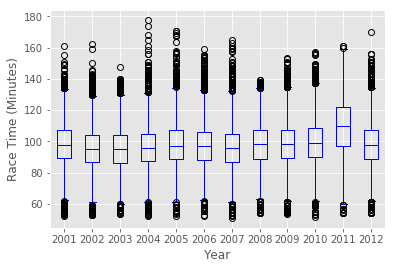

In [41]:
# Boxplot of RaceTime by Year
plt.figure(figsize=(50, 50))
plt.style.use('ggplot')
df_racetime_plot2.plot(kind='box', color='b')
plt.xlabel('Year')
plt.ylabel('Race Time (Minutes)')

<center> Figure 7. Boxlot of Runner's Race Time Distribution per Year. </center> 

In [42]:
# Boxplot in Plotly for nicer visual
import plotly.plotly as py
import cufflinks as cf
import pandas as pd
import numpy as np

In [43]:
py.sign_in('jtsai', 'gcvdhnRmGfPFDJcVvJj1')
cf.set_config_file(offline=False, world_readable=True, theme='ggplot')
layout = go.Layout(
    title = "Race Time Distribution",
    xaxis = dict(
        title = 'Year'),
    yaxis = dict(
       title = "Race Time (Minutes)"))
df_racetime_plot2.iplot(kind='box',
                        layout = layout)

<center> Figure 8. Boxlot of Runner's Race Time Distribution per Year using Plotly\*. </center>  
\*The plot created by Plotly cannot be displayed unless the notebook is re-ran. The following figure is snapshot image of the same plot.
![image](fig_8.png)

### Conclusion
Data wrangling, which is also referred to as data munging, etc. can be a painstakenly laborious process. In fact, its been stated that up to 80% of data analysis is spent on the process of cleaning and preparing data. Being a prerequisite to the rest of the data analysis workflow (visualization, analysis, reporting), it's essential that you become fluent and efficient in data wrangling techniques. This analysis give an example on a work on data wrangling process. Our goal to prepare our data, so we can spend more time focused on understanding the content of your data via visualization, analysis, and reporting. We learn in this process:
* How to work with the different types of data such as numerics, characters, regular expressions, vectors, and times. 
* How to subset each data structure
* How to acquire and parse data from remote locations such as web scraping 
* How to develop functions and use loop control structures to reduce code redundancy
* How to use pipe operators to simplify our code and make it more readable 
* How to reshape the layout of your data, and manipulate, summarize, and join data sets.  


Further work can be done by looking deeper or incorporationg other variables in the data such as locations (city and state). 

### References

Nolan, D. & Lang, T. L. (2015) Data Science in R. A Case Studies Approach to Computational Reasoning and Problem Solving. Boca Raton, FL: CRC Press.  
Wickham, W. & Grolemund, G. (2015) R for Data Science. Sebastopol, CA: OReilly Media, Inc.  
McKinney, W. (2012) Python for Data Analysis. Sebastopol, CA: OReilly Media, Inc.  
Credit Union Cherry Blossom Ten Mile Run, Retrieved February 28, 2017, from http://cherryblossom.org/aboutus/results.php